In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.signal import correlate
from sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings("ignore")

# Thiết lập cấu hình
plt.style.use('seaborn-v0_8')  # Sửa style seaborn
IMG_DIR = 'processed_results'
plt.rcParams['figure.figsize'] = (12, 6)
if not os.path.exists(IMG_DIR):
    os.makedirs(IMG_DIR)

# Hàm lưu biểu đồ
def save_plot(filename):
    plt.tight_layout()
    plt.savefig(f'{IMG_DIR}/{filename}', dpi=300, bbox_inches='tight')

# Hàm vẽ biểu đồ chuỗi thời gian so sánh
def plot_time_series_comparisons(df, columns, titles, filename, figsize=(12, 8)):
    if len(columns) == 1:
        fig, ax = plt.subplots(figsize=figsize)
        axes = [ax]
    else:
        fig, axes = plt.subplots(len(columns), 1, figsize=figsize, sharex=True)
    
    for i, (col_pair, title) in enumerate(zip(columns, titles)):
        for col, label, color, style in col_pair:
            axes[i].plot(df.index, df[col], label=label, color=color, linestyle=style)
        axes[i].set_title(title)
        axes[i].set_xlabel('Time')
        axes[i].set_ylabel('Value')
        axes[i].legend()
        axes[i].grid(True)
    save_plot(filename)

# Hàm phân tích xu hướng và mùa vụ
def analyze_trend_seasonality(series, column_name, period=12):
    decomposition = seasonal_decompose(series, model='additive', period=period)
    
    fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)
    axes[0].plot(series, label='Original', color='blue')
    axes[1].plot(decomposition.trend, label='Trend', color='orange')
    axes[2].plot(decomposition.seasonal, label='Seasonality', color='green')
    axes[3].plot(decomposition.resid, label='Residual', color='red')
    
    for ax, title in zip(axes, ['Original', 'Trend', 'Seasonality', 'Residual']):
        ax.set_title(f'{column_name} - {title}')
        ax.legend(loc='upper left')
        ax.grid(True)
    
    save_plot(f'{column_name}_decomposition.png')
    
    trend = decomposition.trend.dropna()
    trend_direction = "tăng" if (trend.iloc[-1] - trend.iloc[0]) > 0 else "giảm" if (trend.iloc[-1] - trend.iloc[0]) < 0 else "ổn định"
    seasonality_detected = "có" if decomposition.seasonal.abs().mean() > 0.1 else "không rõ"
    
    return decomposition, trend_direction, seasonality_detected

# Hàm kiểm định tính dừng
def check_stationarity(series, column_name):
    result = adfuller(series.dropna())
    p_value = result[1]
    print(f'\nKiểm định ADF cho {column_name}: p-value = {p_value:.4f}')
    
    if p_value < 0.05:
        print(f'{column_name} là chuỗi dừng.')
        return series, 0
    else:
        print(f'{column_name} không dừng. Áp dụng sai phân cấp 1...')
        diff_series = series.diff().dropna()
        result_diff = adfuller(diff_series)
        p_value_diff = result_diff[1]
        print(f'p-value sau sai phân cấp 1: {p_value_diff:.4f}')
        if p_value_diff < 0.05:
            print(f'{column_name} dừng sau sai phân cấp 1.')
            return diff_series, 1
        else:
            print(f'{column_name} vẫn không dừng. Áp dụng sai phân cấp 2...')
            diff_series_2 = diff_series.diff().dropna()
            result_diff_2 = adfuller(diff_series_2)
            p_value_diff_2 = result_diff_2[1]
            print(f'p-value sau sai phân cấp 2: {p_value_diff_2:.4f}')
            if p_value_diff_2 < 0.05:
                print(f'{column_name} dừng sau sai phân cấp 2.')
                return diff_series_2, 2
            else:
                print(f'{column_name} vẫn không dừng sau sai phân cấp 2.')
                return diff_series_2, 2

# Hàm phát hiện dị biệt
def detect_anomalies(series, method='zscore', window=12, threshold=2):
    if method == 'zscore':
        rolling_mean = series.rolling(window=window).mean()
        rolling_std = series.rolling(window=window).std()
        anomalies = (series > (rolling_mean + threshold * rolling_std)) | (series < (rolling_mean - threshold * rolling_std))
    elif method == 'iqr':
        q1, q3 = series.quantile(0.25), series.quantile(0.75)
        iqr = q3 - q1
        anomalies = (series < (q1 - 1.5 * iqr)) | (series > (q3 + 1.5 * iqr))
    elif method == 'isolation_forest':
        model = IsolationForest(contamination=0.1, random_state=42)
        series_reshaped = series.values.reshape(-1, 1)
        anomalies = model.fit_predict(series_reshaped) == -1
    return anomalies

# Hàm vẽ biểu đồ dị biệt
def plot_anomalies(df, series_col, anomalies, title, filename):
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[series_col], label=series_col, color='blue')
    plt.plot(df.index[anomalies], df[series_col][anomalies], 'ro', label='Anomalies')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    save_plot(filename)

# Hàm vẽ scatter plot
def plot_scatter_relationships(df, target, exog_vars, filename):
    fig, axes = plt.subplots(1, len(exog_vars), figsize=(12, 4))
    if len(exog_vars) == 1:
        axes = [axes]
    for i, var in enumerate(exog_vars):
        axes[i].scatter(df[var], df[target], alpha=0.5)
        axes[i].set_xlabel(var)
        axes[i].set_ylabel(target)
        axes[i].set_title(f'{target} vs {var}')
        axes[i].grid(True)
    plt.tight_layout()
    save_plot(filename)

# Hàm phân tích cross-correlation
def cross_correlation_analysis(df, target, exog_vars, max_lags=12):
    print(f"\nCross-correlation analysis for {target}:")
    for var in exog_vars:
        corr = correlate(df[target].dropna(), df[var].dropna(), mode='full')
        lags = np.arange(-max_lags, max_lags + 1)
        corr = corr[len(corr)//2 - max_lags:len(corr)//2 + max_lags + 1]
        plt.figure(figsize=(10, 4))
        plt.stem(lags, corr)
        plt.title(f'Cross-correlation: {target} vs {var}')
        plt.xlabel('Lag')
        plt.ylabel('Correlation')
        plt.grid(True)
        save_plot(f'cross_correlation_{target}_vs_{var}.png')

# Hàm dự báo ARIMA
def simple_arima_forecast(series, steps=12):
    model = ARIMA(series, order=(1, 1, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=steps)
    forecast_index = pd.date_range(start=series.index[-1] + pd.offsets.MonthBegin(1), periods=steps, freq='MS')
    
    plt.figure(figsize=(12, 6))
    plt.plot(series.index, series, label='Historical CPI', color='blue')
    plt.plot(forecast_index, forecast, label='Forecast', color='orange', linestyle='--')
    plt.title('CPI Forecast using ARIMA')
    plt.xlabel('Time')
    plt.ylabel('CPI')
    plt.legend()
    plt.grid(True)
    save_plot('cpi_arima_forecast.png')
    return forecast

# Hàm kiểm tra outliers
def check_outliers(df, columns):
    print("\nKiểm tra giá trị ngoại lai:")
    for col in columns:
        q1, q3 = df[col].quantile(0.25), df[col].quantile(0.75)
        iqr = q3 - q1
        outliers = df[(df[col] < (q1 - 1.5 * iqr)) | (df[col] > (q3 + 1.5 * iqr))][col]
        print(f"{col}: {len(outliers)} giá trị ngoại lai\n", outliers)



In [16]:
# Đọc dữ liệu CPI
path_cpi = r"data/cpi.csv"
try:
    df = pd.read_csv(path_cpi)
except FileNotFoundError:
    print(f"File {path_cpi} không tồn tại!")
    exit()

# Đọc dữ liệu ngoại sinh
path_exog = r"data/exog_data.csv"
try:
    exog_data = pd.read_csv(path_exog, index_col='Ngày', parse_dates=True)
except FileNotFoundError:
    print(f"File {path_exog} không tồn tại! Tạo lãi suất giả lập.")
    exog_data = None

print(df.head(15))
if exog_data is not None:
    print(exog_data.head(15))

    tg       t    cpi
0    0  Jan-95  103.8
1    1  Feb-95  103.4
2    2  Mar-95  100.2
3    3  Apr-95  101.0
4    4  May-95  101.8
5    5  Jun-95  100.8
6    6  Jul-95  100.0
7    7  Aug-95  100.3
8    8  Sep-95  100.5
9    9  Oct-95  100.1
10  10  Nov-95  100.1
11  11  Dec-95  100.3
12  12  Jan-96  100.9
13  13  Feb-96  102.5
14  14  Mar-96  100.8
            oil_price  gold_price  interest_rate
Ngày                                            
1995-01-01      18.39       377.7            NaN
1995-02-01      18.49       378.3            NaN
1995-03-01      19.17       394.3            NaN
1995-04-01      20.38       388.5            NaN
1995-05-01      18.89       387.6            NaN
1995-06-01      17.40       385.6            NaN
1995-07-01      17.56       388.4            NaN
1995-08-01      17.84       386.9            NaN
1995-09-01      17.54       386.5            NaN
1995-10-01      17.64       384.3            NaN
1995-11-01      18.18       388.6            NaN
1995-12-01 

In [17]:
# Tiền xử lý CPI
df['time'] = pd.to_datetime(df['t'], format='%b-%y')
df.drop(columns=['t', 'tg'], inplace=True, errors='ignore')
df.columns = ['cpi', 'time']
df.set_index('time', inplace=True)
df = df.asfreq('MS', method='ffill')  # Đặt tần suất và điền giá trị thiếu

# Kiểm tra dữ liệu đủ để phân tích
if len(df) < 24:
    raise ValueError("Dữ liệu quá ngắn (cần ít nhất 24 tháng).")

# Xử lý giá trị thiếu trong CPI
print("Giá trị thiếu trong CPI:", df.isnull().sum().to_dict())
df['cpi'] = df['cpi'].interpolate(method='linear')

Giá trị thiếu trong CPI: {'cpi': 0}


In [18]:
# Gộp dữ liệu
if exog_data is not None:
    exog_data = exog_data.reindex(df.index, method='ffill').bfill()
    merged_df = df.merge(exog_data[['oil_price', 'gold_price', 'interest_rate']], 
                        left_index=True, right_index=True, how='left').fillna(method='ffill').bfill()
    print("Giá trị thiếu trong merged_df:", merged_df.isnull().sum().to_dict())
else:
    print("Tạo lãi suất giả lập vì không tìm thấy exog_data.")
    np.random.seed(42)
    df['interest_rate'] = 5 + np.random.normal(0, 0.5, len(df))
    merged_df = df.copy()

print(merged_df.head(15))


Giá trị thiếu trong merged_df: {'cpi': 0, 'oil_price': 0, 'gold_price': 0, 'interest_rate': 0}
              cpi  oil_price  gold_price  interest_rate
time                                                   
1995-01-01  103.8      18.39       377.7          25.41
1995-02-01  103.4      18.49       378.3          25.41
1995-03-01  100.2      19.17       394.3          25.41
1995-04-01  101.0      20.38       388.5          25.41
1995-05-01  101.8      18.89       387.6          25.41
1995-06-01  100.8      17.40       385.6          25.41
1995-07-01  100.0      17.56       388.4          25.41
1995-08-01  100.3      17.84       386.9          25.41
1995-09-01  100.5      17.54       386.5          25.41
1995-10-01  100.1      17.64       384.3          25.41
1995-11-01  100.1      18.18       388.6          25.41
1995-12-01  100.3      19.55       388.1          25.41
1996-01-01  100.9      17.74       408.5          25.41
1996-02-01  102.5      19.54       401.2          25.41
1996-03-0

In [19]:
# Làm mượt dữ liệu
window_size = 3
merged_df['cpi_smoothed'] = merged_df['cpi'].rolling(window=window_size, center=True).mean().fillna(merged_df['cpi'])

# Chuyển đổi log
if (merged_df['cpi'] <= 0).any():
    print("Cảnh báo: Có giá trị CPI âm hoặc bằng 0, đã được clip để tính log.")
merged_df['cpi_log'] = np.log(merged_df['cpi'].clip(lower=1e-6))

# Thêm cột tháng và năm
merged_df['month'] = merged_df.index.month
merged_df['year'] = merged_df.index.year

# Kiểm tra outliers
check_outliers(merged_df, ['cpi', 'oil_price', 'gold_price', 'interest_rate'])



Kiểm tra giá trị ngoại lai:
cpi: 26 giá trị ngoại lai
 time
1995-01-01    103.80
1995-02-01    103.40
1996-02-01    102.50
1998-02-01    102.20
2000-03-01     98.90
2002-02-01    102.20
2003-02-01    102.20
2004-02-01    103.00
2005-02-01    102.50
2006-02-01    102.10
2007-02-01    102.20
2007-12-01    102.90
2008-01-01    102.38
2008-02-01    103.56
2008-03-01    102.99
2008-04-01    102.20
2008-05-01    103.91
2008-06-01    102.14
2010-02-01    101.96
2010-12-01    101.98
2011-02-01    102.09
2011-03-01    102.17
2011-04-01    103.32
2011-05-01    102.21
2012-09-01    102.20
2020-04-01     98.46
Name: cpi, dtype: float64
oil_price: 0 giá trị ngoại lai
 Series([], Freq: MS, Name: oil_price, dtype: float64)
gold_price: 0 giá trị ngoại lai
 Series([], Freq: MS, Name: gold_price, dtype: float64)
interest_rate: 0 giá trị ngoại lai
 Series([], Freq: MS, Name: interest_rate, dtype: float64)



Phân tích cpi:
Xu hướng: giảm
Tính mùa vụ: có

Kiểm định ADF cho cpi: p-value = 0.0031
cpi là chuỗi dừng.


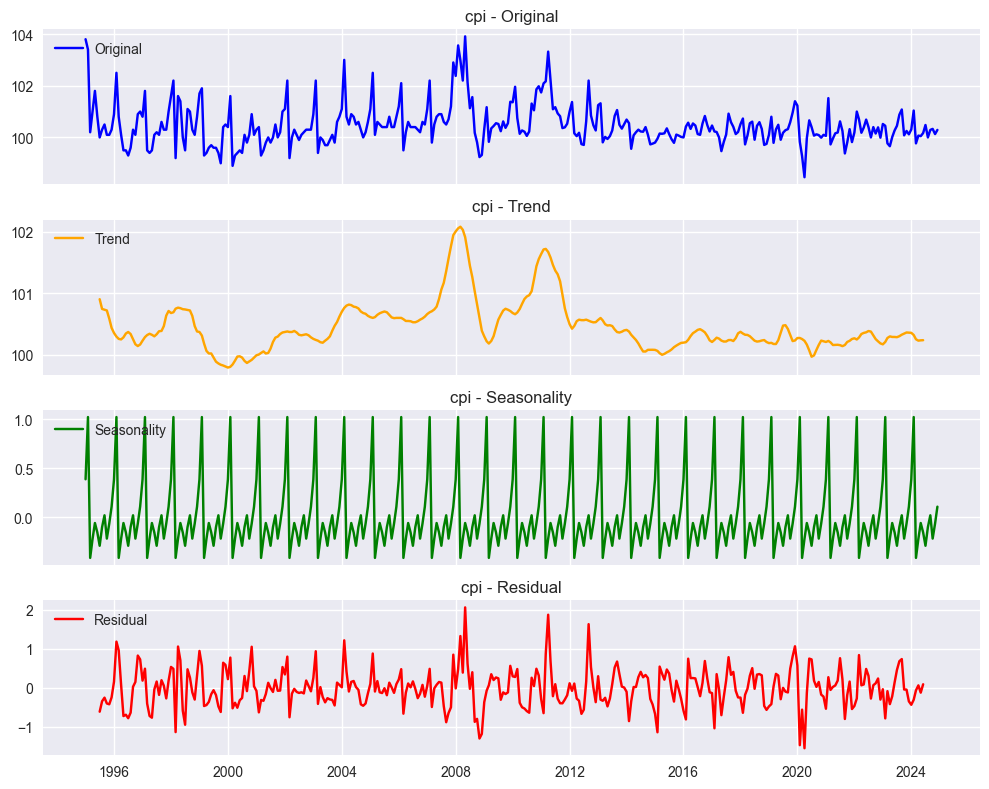

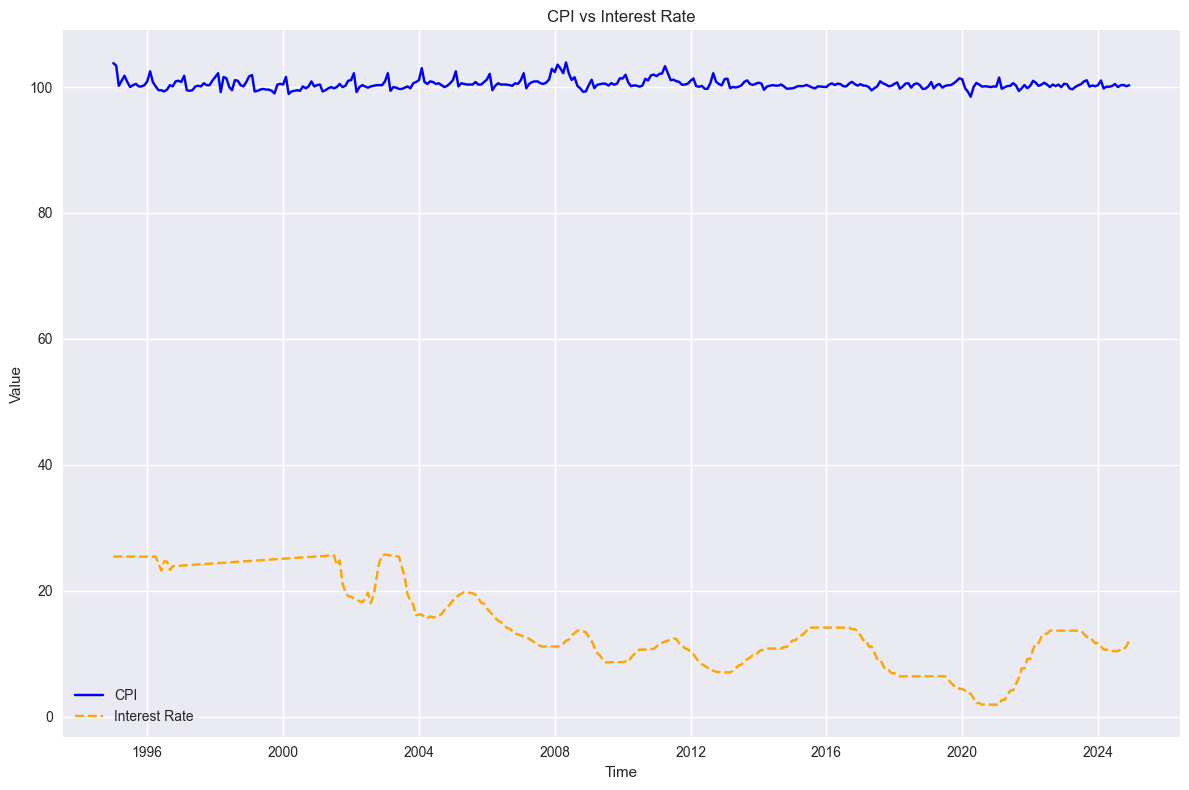

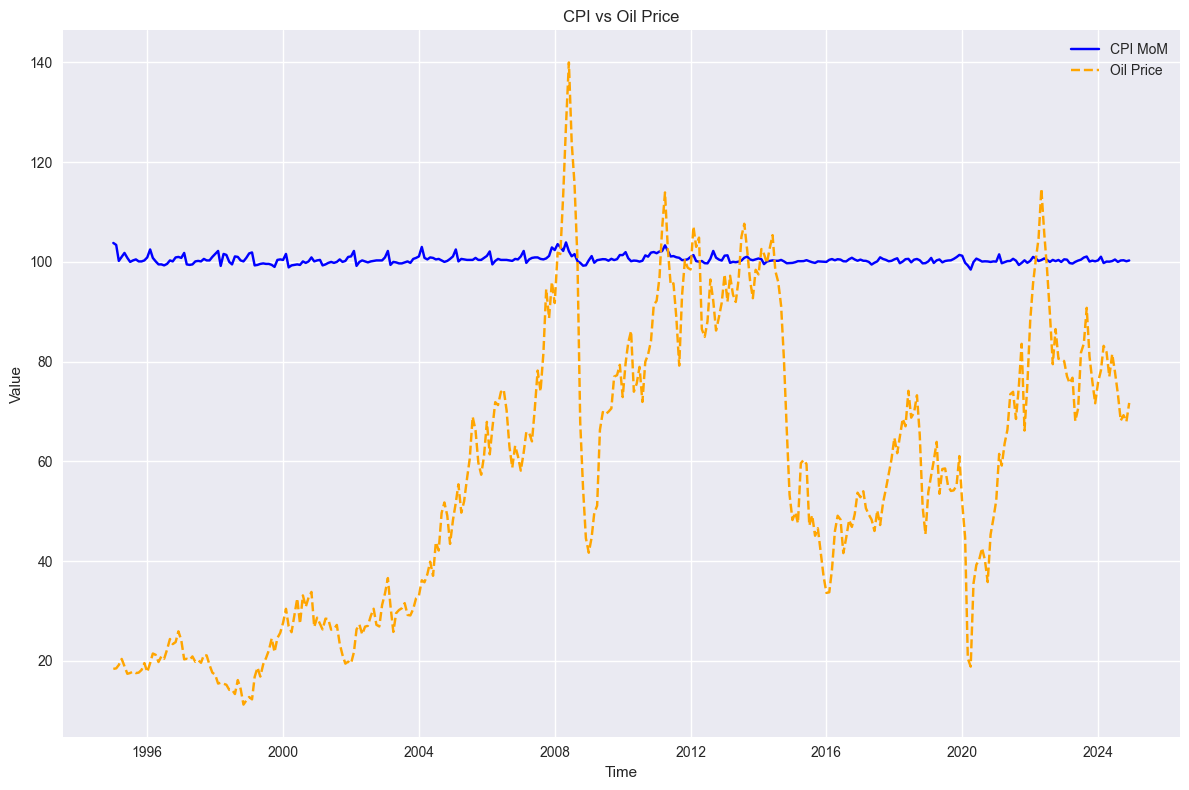

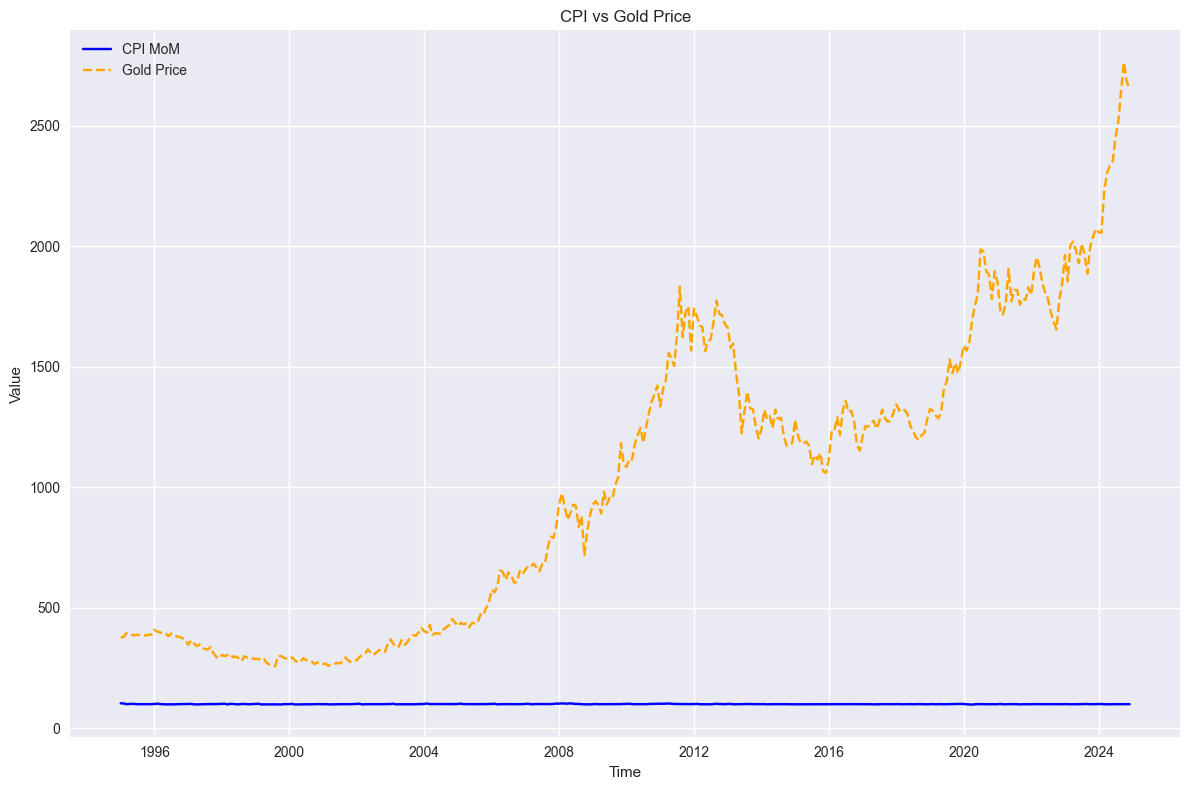

In [20]:
# Phân tích đặc tính chuỗi
for col in ['cpi']:
    print(f"\nPhân tích {col}:")
    decomposition, trend, seasonality = analyze_trend_seasonality(merged_df[col], col)
    print(f'Xu hướng: {trend}')
    print(f'Tính mùa vụ: {seasonality}')
    diff_series, diff_order = check_stationarity(merged_df[col], col)
    merged_df[f'{col}_diff'] = merged_df[col].diff()

# So sánh với interest_rate
plot_time_series_comparisons(
    merged_df,
    [[('cpi', 'CPI', 'blue', '-'), ('interest_rate', 'Interest Rate', 'orange', '--')]],
    ['CPI vs Interest Rate'],
    'cpi_vs_interest_rate.png'
)

# So sánh với giá dầu
plot_time_series_comparisons(
    merged_df,
    [[('cpi', 'CPI MoM', 'blue', '-'), ('oil_price', 'Oil Price', 'orange', '--')]],
    ['CPI vs Oil Price'],
    'cpi_vs_oil_price.png'
)

# So sánh với giá vàng
plot_time_series_comparisons(
    merged_df,
    [[('cpi', 'CPI MoM', 'blue', '-'), ('gold_price', 'Gold Price', 'orange', '--')]],
    ['CPI vs Gold Price'],
    'cpi_vs_gold_price.png'
)


Tương quan giữa CPI và các biến kinh tế:
                    cpi
interest_rate -0.037376
oil_price      0.249712
gold_price    -0.027462


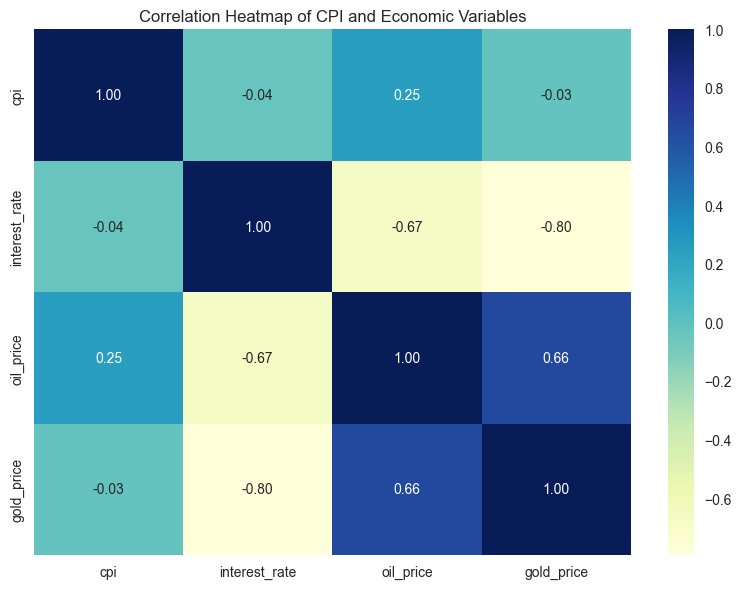

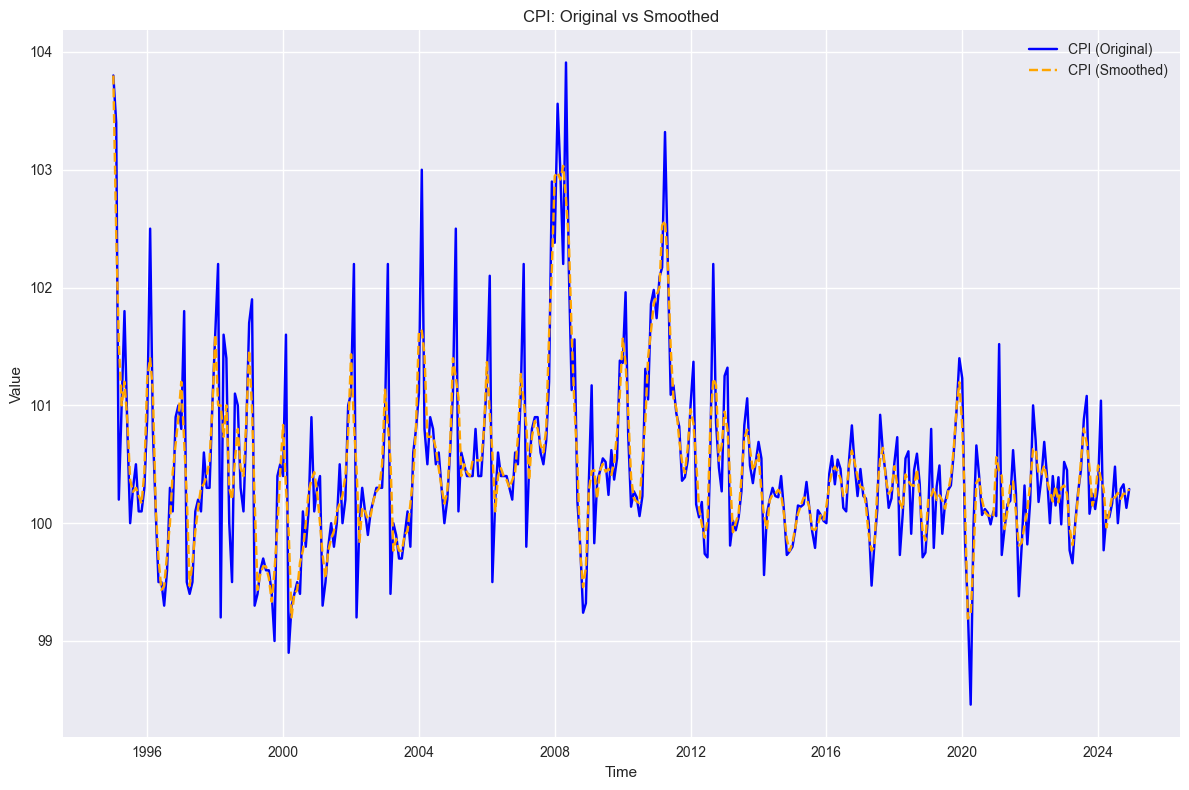

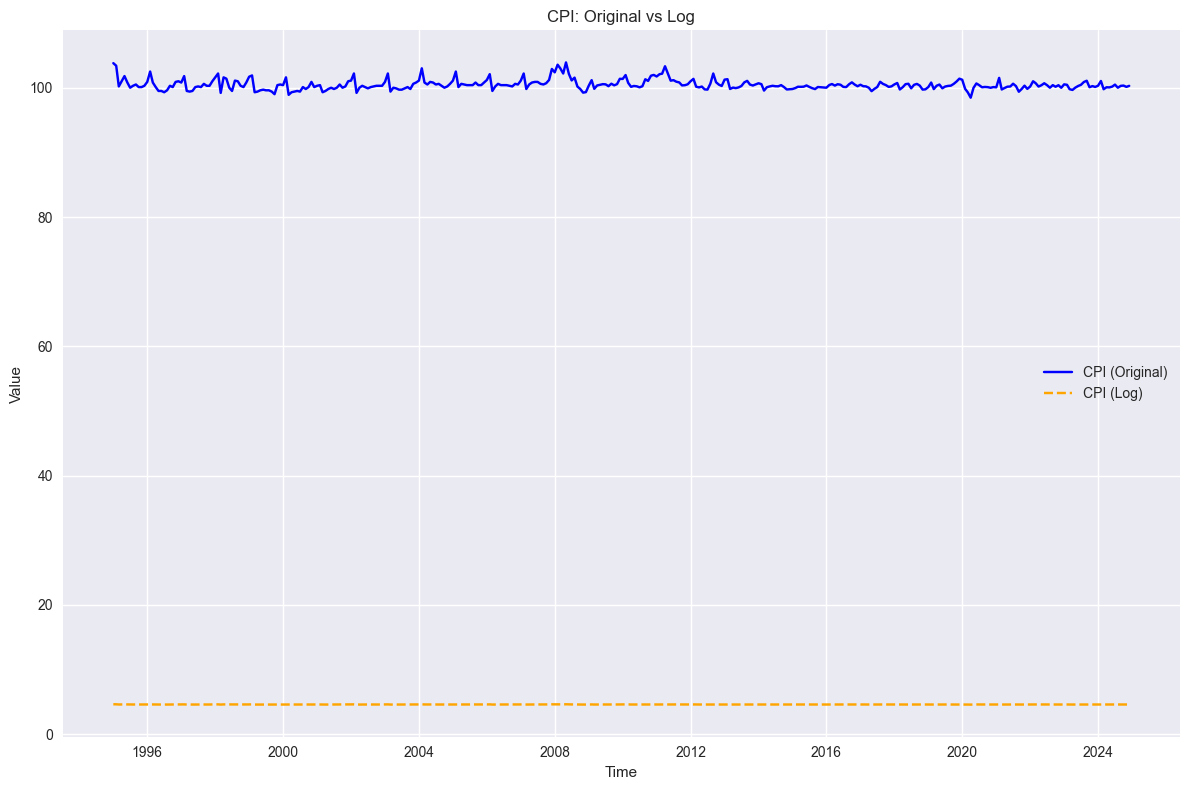

In [21]:
# Phân tích tương quan
print("\nTương quan giữa CPI và các biến kinh tế:")
corr_matrix = merged_df[['cpi', 'interest_rate', 'oil_price', 'gold_price']].corr()
print(corr_matrix[['cpi']].loc[['interest_rate', 'oil_price', 'gold_price']])

# Biểu đồ heatmap tương quan
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Correlation Heatmap of CPI and Economic Variables')
save_plot('cpi_correlation_heatmap.png')

# Biểu đồ so sánh smoothed và log
plot_time_series_comparisons(
    merged_df,
    [[('cpi', 'CPI (Original)', 'blue', '-'), ('cpi_smoothed', 'CPI (Smoothed)', 'orange', '--')]],
    ['CPI: Original vs Smoothed'],
    'cpi_original_vs_smoothed.png'
)

plot_time_series_comparisons(
    merged_df,
    [[('cpi', 'CPI (Original)', 'blue', '-'), ('cpi_log', 'CPI (Log)', 'orange', '--')]],
    ['CPI: Original vs Log'],
    'cpi_original_vs_log.png'
)


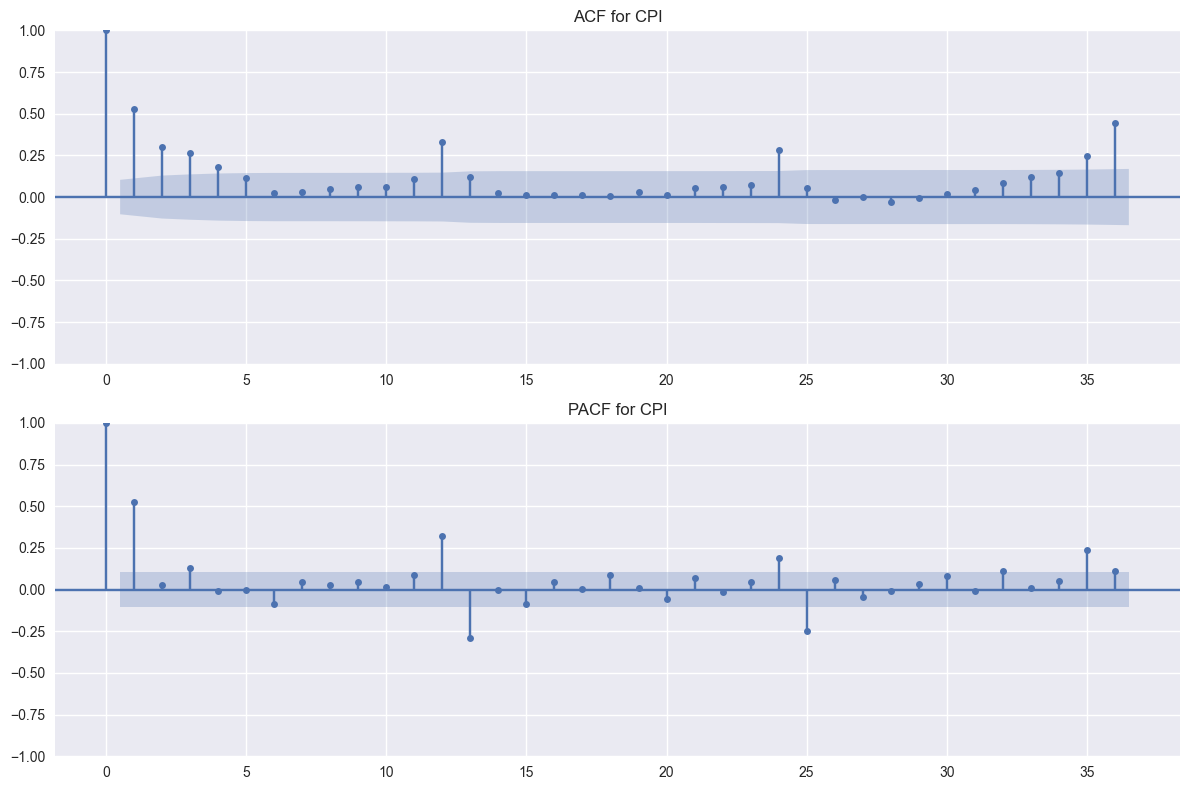

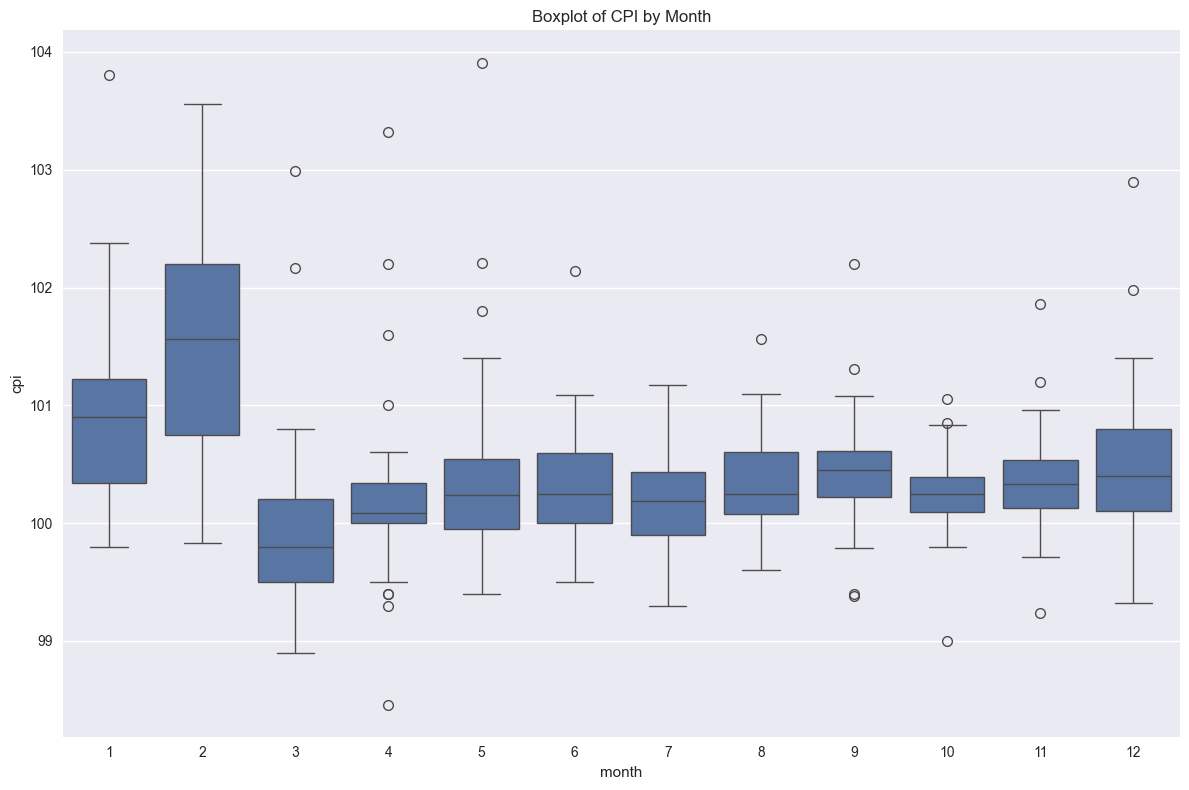

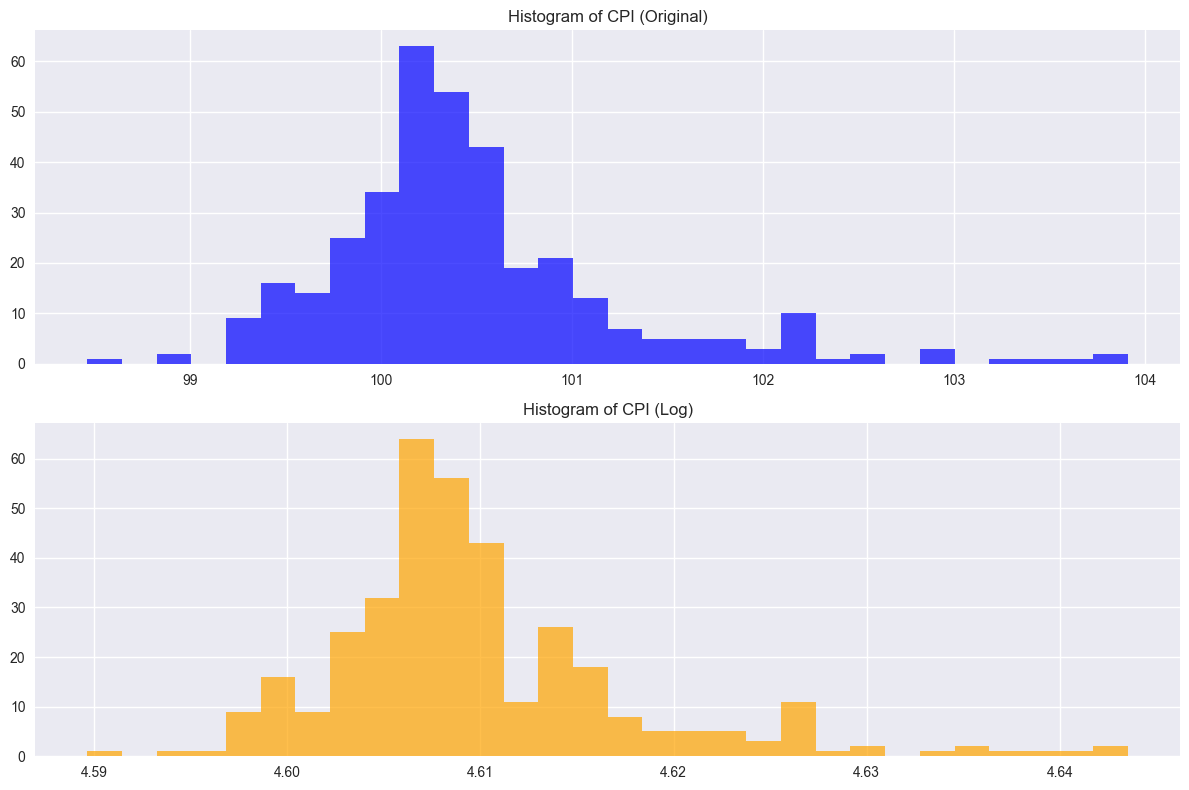

In [22]:
# Biểu đồ ACF và PACF
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(merged_df['cpi'].dropna(), lags=36, ax=axes[0], title='ACF for CPI')
plot_pacf(merged_df['cpi'].dropna(), lags=36, ax=axes[1], title='PACF for CPI')
save_plot('cpi_acf_pacf_plots.png')

# Boxplot theo tháng
fig, ax = plt.subplots(figsize=(12, 8))
sns.boxplot(x='month', y='cpi', data=merged_df, ax=ax)
ax.set_title('Boxplot of CPI by Month')
save_plot('cpi_boxplot_by_month.png')

# Histogram
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
axes[0].hist(merged_df['cpi'].dropna(), bins=30, color='blue', alpha=0.7)
axes[0].set_title('Histogram of CPI (Original)')
axes[1].hist(merged_df['cpi_log'].dropna(), bins=30, color='orange', alpha=0.7)
axes[1].set_title('Histogram of CPI (Log)')
save_plot('cpi_histogram.png')


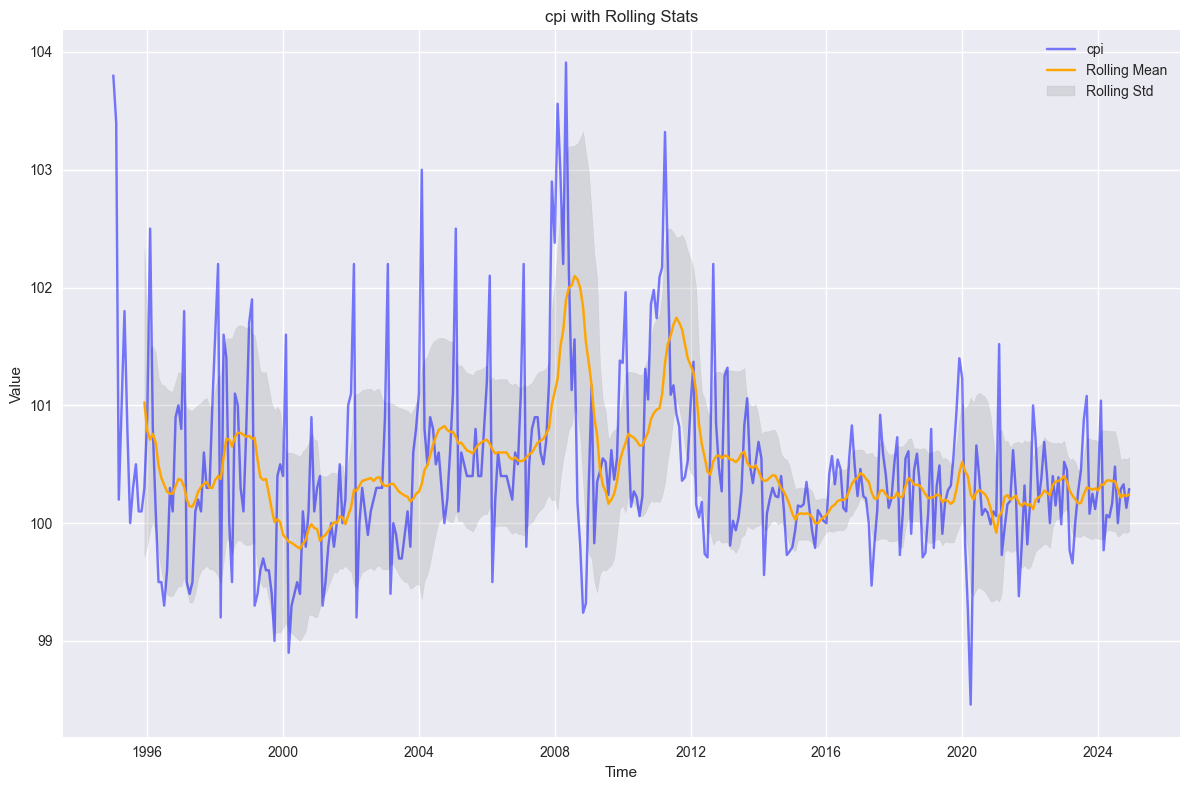

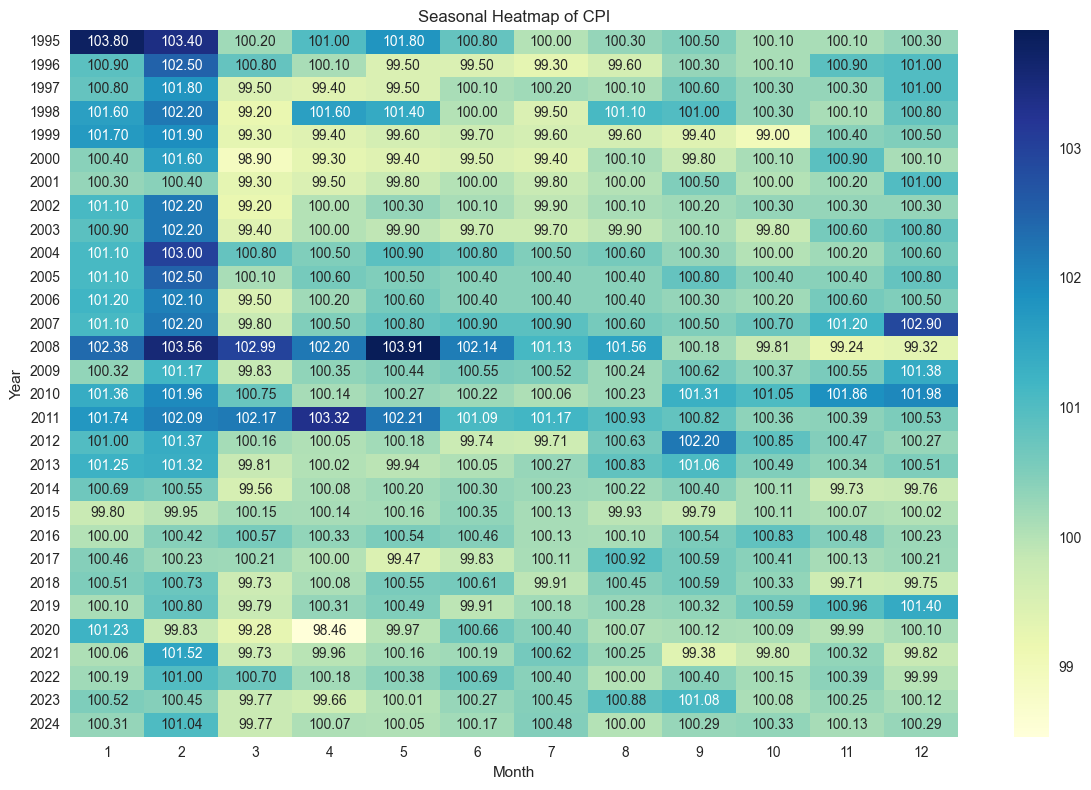

In [23]:
# Rolling stats
fig, ax = plt.subplots(figsize=(12, 8))
col = 'cpi'
window = 12
merged_df[f'{col}_rolling_mean'] = merged_df[col].rolling(window=window).mean()
merged_df[f'{col}_rolling_std'] = merged_df[col].rolling(window=window).std()
ax.plot(merged_df[col], label=col, color='blue', alpha=0.5)
ax.plot(merged_df[f'{col}_rolling_mean'], label='Rolling Mean', color='orange')
ax.fill_between(merged_df.index, 
                merged_df[f'{col}_rolling_mean'] - merged_df[f'{col}_rolling_std'], 
                merged_df[f'{col}_rolling_mean'] + merged_df[f'{col}_rolling_std'], 
                color='gray', alpha=0.2, label='Rolling Std')
ax.set_title(f'{col} with Rolling Stats')
ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.legend()
ax.grid(True)
save_plot('cpi_rolling_stats.png')

# Heatmap mùa vụ
fig, ax = plt.subplots(figsize=(12, 8))
col, title = 'cpi', 'CPI'
pivot = merged_df.pivot_table(values=col, index='year', columns='month', aggfunc='mean')
sns.heatmap(pivot, cmap='YlGnBu', annot=True, fmt='.2f', ax=ax)
ax.set_title(f'Seasonal Heatmap of {title}')
ax.set_xlabel('Month')
ax.set_ylabel('Year')
save_plot('cpi_seasonal_heatmap.png')


Cross-correlation analysis for cpi:

Thống kê mô tả cho các biến:
              cpi   oil_price   gold_price  interest_rate
count  360.000000  360.000000   360.000000     360.000000
mean   100.468750   56.378389  1008.333333      14.731203
std      0.790726   28.610548   620.704917       6.993014
min     98.460000   11.220000   257.300000       1.900000
25%    100.050000   29.002500   385.975000       9.905500
50%    100.300000   54.405000  1074.550000      13.150000
75%    100.800000   78.222500  1447.950000      22.412500
max    103.910000  140.000000  2761.600000      25.750000

Dữ liệu đã xử lý được lưu vào 'data/data.csv'.


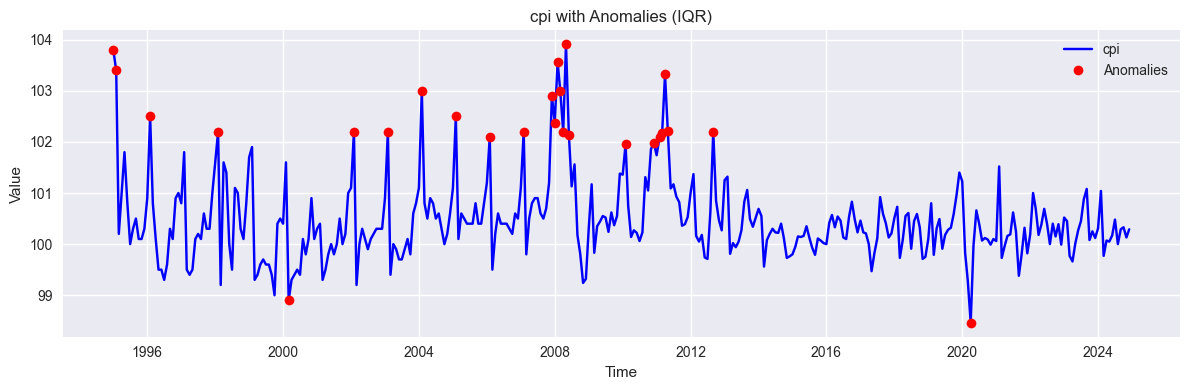

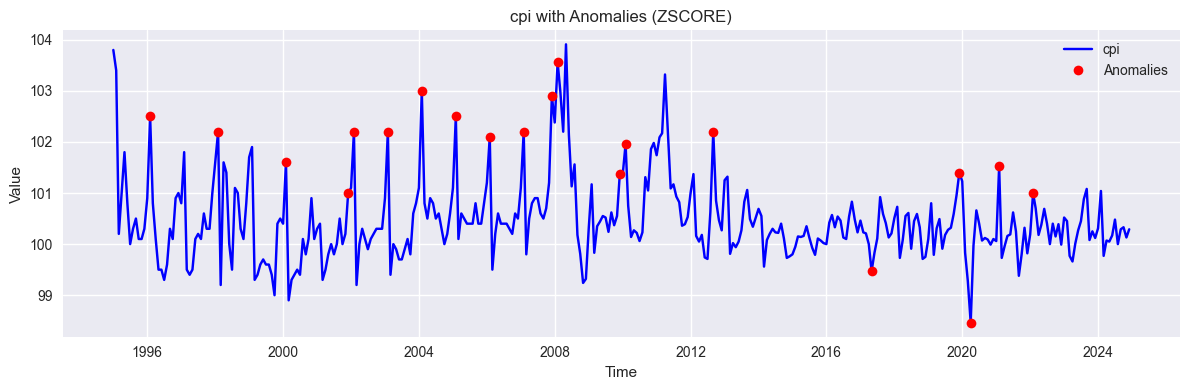

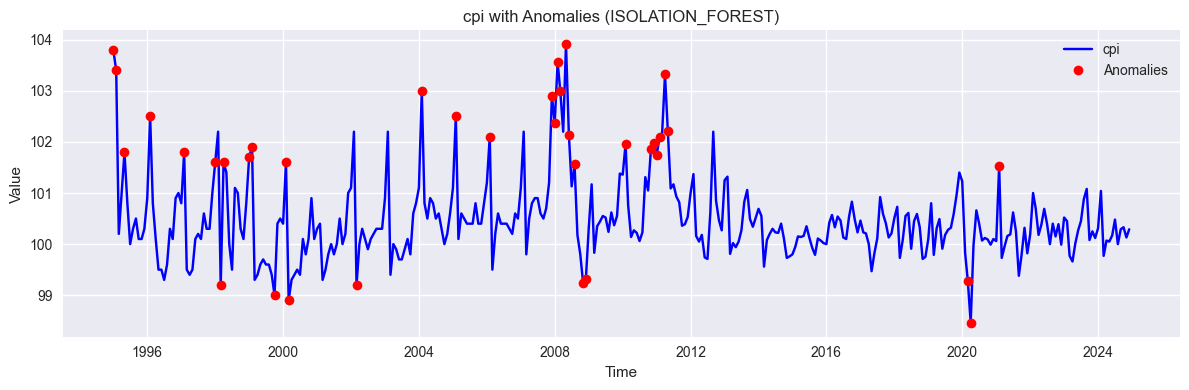

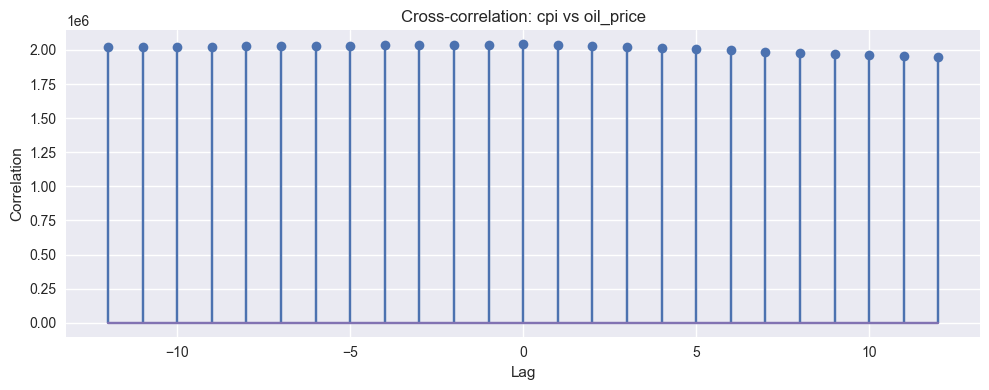

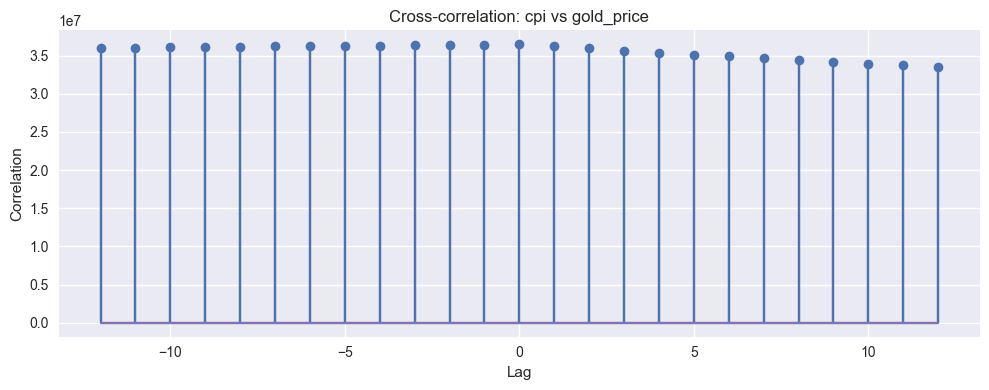

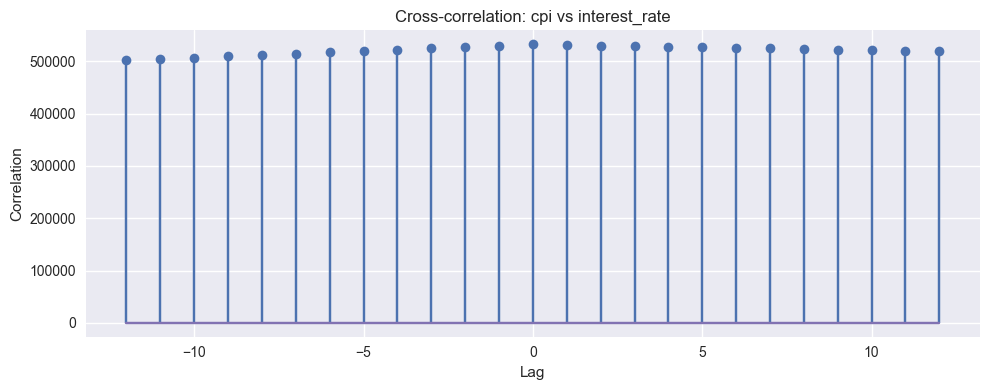

In [24]:
# Phát hiện dị biệt
for col in ['cpi']:
    for method, suffix in [('iqr', 'iqr'), ('zscore', 'zscore'), ('isolation_forest', 'isolation_forest')]:
        anomalies = detect_anomalies(merged_df[col], method=method)
        plot_anomalies(merged_df, col, anomalies, f'{col} with Anomalies ({method.upper()})',
                       f'{col}_anomalies_{suffix}.png')

# Phân tích cross-correlation
cross_correlation_analysis(merged_df, 'cpi', ['oil_price', 'gold_price', 'interest_rate'])

# Thống kê mô tả
print("\nThống kê mô tả cho các biến:")
print(merged_df[['cpi', 'oil_price', 'gold_price', 'interest_rate']].describe())

# Lưu dữ liệu
merged_df.to_csv('data/data.csv')
print("\nDữ liệu đã xử lý được lưu vào 'data/data.csv'.")